In [1]:
import numpy as np
import pandas as pd
import random
import gym

In [2]:
import logging
logging.getLogger().setLevel(logging.WARNING)

In [3]:
from wutils import get_possible_actions

In [53]:
env = gym.make('wazuhl_gym:wazuhl-v0')
actions = get_possible_actions(env)

In [3]:
fnames = ["3randtraj1.npy", "3randtraj2.npy", "3randtraj3.npy", "3randtraj4.npy"]

In [4]:
all_records = np.concatenate([np.load(fname, allow_pickle=True) for fname in fnames])

In [5]:
len(all_records)

13500

In [6]:
from wutils import Record

In [7]:
all_records = [Record(*el) for el in all_records]

In [8]:
data = pd.DataFrame(all_records)

In [9]:
data = data.sample(frac=1).reset_index(drop=True)

In [10]:
msk = np.random.rand(len(data)) < 0.8

train = data[msk]
test = data[~msk]

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [12]:
from wutils import generate_batches

In [13]:
batch_size = 32
batches, vocabs = generate_batches(train, batch_size, limit=len(train), bpe_iterations=50)

In [14]:
import logging
mpl_logger = logging.getLogger("matplotlib")
mpl_logger.setLevel(logging.WARNING) 

In [15]:
import matplotlib.pyplot as plt

In [22]:
batch = batches[0]
batch.state_lens

tensor([432., 800., 800., 550., 800., 800., 134., 800., 800., 800., 800., 701.,
        800., 800., 800., 643., 224., 800., 800., 800., 800., 148., 800., 800.,
        800., 463., 800., 800., 216., 800., 800., 800.])

Epoch: 9, Loss: 0.8133809566497803


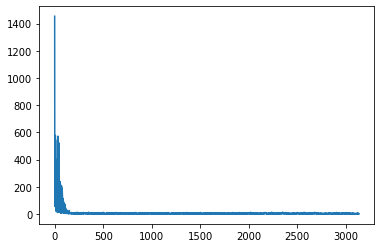

KeyboardInterrupt: 

In [23]:
from IPython.display import clear_output
from models.supervised_base_nn import BaseModel

vocab, actions_vocab, bpe_order = vocabs
model = BaseModel(vocab, actions_vocab, batch_size=batch_size)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

loss_history = []
for epoch in range(300): 
    for batch in batches:
        model.zero_grad()
        scores = model(batch.state, batch.actions, batch.state_lens.view(batch_size, 1))
        loss = loss_function(scores, batch.target)
        loss_history.append(loss.detach().numpy())
        loss.backward()
        optimizer.step()
        clear_output()
        plt.plot(loss_history)
        print("Epoch: {}, Loss: {}".format(epoch, loss_history[-1]))
        plt.show()

In [252]:
from wutils import ModelInfo

ImportError: cannot import name 'ModelInfo'

In [27]:
model_info = ModelInfo(model, vocab, actions_vocab, bpe_order)

In [29]:
import pickle
pickle.dump(model_info, open("model1.mdlinfo", "wb"))

BaseModel(
  (embedding): Embedding(104, 128, padding_idx=0)
  (actions_embedding): Embedding(102, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (actions_lstm): LSTM(128, 128, batch_first=True)
  (linear): Linear(in_features=256, out_features=128, bias=True)
  (linear_actions): Linear(in_features=128, out_features=64, bias=True)
  (length_enc): Linear(in_features=1, out_features=64, bias=True)
  (output): Linear(in_features=256, out_features=1, bias=True)
)